# Real-Time AML Dataset

## What to do
- **Optimize reading** by using only 100,000 transactions and unpack embedded metadata
- **Create baseline** data quality and target imbalance **analysis**
- **Build behavioral features** at the user, device, and merchant levels
- **Visualize** key patterns (amounts, transfer types, time, risk score)
- **Prepare** a user-level split and encoding **pipeline**, explaining the choice of transformations

In [74]:
import os
import ast
import re
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupShuffleSplit

sns.set_theme(style='ticks', palette='deep')
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

## Loading and initial optimization
We read 100k lines (enough for reconnaissance), casting types immediately after reading to reduce memory consumption and prevent accidental casts later

In [75]:
load_dotenv('../.env')
DATA_PATH = Path(os.getenv('DATA_PATH')).expanduser()
CSV_PATH = DATA_PATH / 'raw/AMLNet_August_2025.csv' #~/Real-Time-Anti-Money-Laundering-Detection/data/raw/AMLNet_August_2025.csv
ROWS_TO_READ = 10000

raw_df = pd.read_csv(CSV_PATH, nrows=ROWS_TO_READ)

int_cols = ['day_of_month', 'day_of_week', 'month', 'hour', 'step']
for col in int_cols:
    raw_df[col] = raw_df[col].astype('int16')

category_cols = ['type', 'category', 'nameOrig', 'nameDest', 'laundering_typology']
for col in category_cols:
    raw_df[col] = raw_df[col].astype('category')

for target_col in ['isMoneyLaundering', 'isFraud']:
    raw_df[target_col] = raw_df[target_col].astype(bool)

print(f'Dataset shape: {raw_df.shape}')
raw_df.head(3)

Dataset shape: (10000, 17)


,step,type,amount,category,nameOrig,nameDest,oldbalanceOrg,newbalanceOrig,isFraud,isMoneyLaundering,laundering_typology,metadata,fraud_probability,hour,day_of_week,day_of_month,month
0,0,DEBIT,298.84,Other,C8083,C7053,"455,489.32","455,190.48",False,False,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2
1,0,DEBIT,93.09,Recreation,C5575,C1117,"229,508.29","229,415.20",False,False,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2
2,0,EFTPOS,155.64,Healthcare,C1549,C1423,"202,568.81","202,413.16",False,False,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2


## Unpacking metadata and normalizing types
The metadata contains nested dictionaries with geography, device, merchant, and risk indicators. We'll convert Python-like strings into valid JSON, split them into individual features, and convert numeric fields

In [76]:
def normalize_python_json_string(value: str) -> str:
    # json to str
    pattern = r'datetime\.datetime\((.*?)\)'

    def repl(match):
        args = match.group(1).split(',')
        nums = [int(a.strip()) for a in args]
        dt = datetime(*nums)
        return f"'{dt.isoformat()}'"

    return re.sub(pattern, repl, value)


def parse_metadata(value):
    if isinstance(value, dict):
        return value
    cleaned = normalize_python_json_string(value)
    return ast.literal_eval(cleaned)


def expand_nested_dict(series: pd.Series, prefix: str) -> pd.DataFrame:
    expanded = series.apply(lambda x: x if isinstance(x, dict) else {}).apply(pd.Series)
    if expanded is None:
        return pd.DataFrame()
    return expanded.add_prefix(f'{prefix}_')


def fill_object_nan(frame: pd.DataFrame) -> pd.DataFrame:
    # Nan change to 'Unknown'
    for col in frame.columns:
        if frame[col].dtype == object:
            frame[col] = frame[col].fillna('Unknown')
    return frame

In [77]:
meta = raw_df.pop('metadata').apply(parse_metadata)
meta_df = meta.apply(pd.Series)

# Fill gaps
location = fill_object_nan(expand_nested_dict(meta_df['location'], 'loc'))
device = fill_object_nan(expand_nested_dict(meta_df['device_info'], 'device'))
merchant = fill_object_nan(expand_nested_dict(meta_df['merchant_info'], 'merch'))
risk = fill_object_nan(expand_nested_dict(meta_df['risk_indicators'], 'risk'))

# For each subcategory we create additional columns
if 'loc_postcode' in location:
    location['loc_postcode'] = pd.to_numeric(location['loc_postcode'], errors='coerce')
if 'merch_avg_transaction' in merchant:
    merchant['merch_avg_transaction'] = pd.to_numeric(merchant['merch_avg_transaction'], errors='coerce')
for risk_col in ['risk_amount_vs_average', 'risk_customer_risk_score', 'risk_risk_score']:
    if risk_col in risk:
        risk[risk_col] = pd.to_numeric(risk[risk_col], errors='coerce')

# Change dtype and fill gaps
meta_subset = meta_df[['timestamp', 'payment_method']].copy()
meta_subset['timestamp'] = pd.to_datetime(meta_subset['timestamp'])
meta_subset['payment_method'] = meta_subset['payment_method'].fillna('Unknown')

frames = [raw_df, location, device, merchant, risk, meta_subset]
df = pd.concat(frames, axis=1).copy()
print(f'After unpacking: {df.shape[1]} columns')
df.head(3)

After unpacking: 35 columns


,step,type,amount,category,nameOrig,nameDest,oldbalanceOrg,newbalanceOrig,isFraud,isMoneyLaundering,...,merch_risk_level,merch_avg_transaction,risk_amount_vs_average,risk_customer_risk_score,risk_category_risk,risk_risk_score,risk_unusual_time,risk_unusual_location,timestamp,payment_method
0,0,DEBIT,298.84,Other,C8083,C7053,"455,489.32","455,190.48",False,False,...,Unknown,NaN,2.40,100.00,medium,66.30,False,False,2025-02-04 12:22:36.770518,BSB_Account
1,0,DEBIT,93.09,Recreation,C5575,C1117,"229,508.29","229,415.20",False,False,...,Unknown,NaN,2.09,100.00,medium,62.17,False,False,2025-02-04 12:44:31.770518,CardNumber
2,0,EFTPOS,155.64,Healthcare,C1549,C1423,"202,568.81","202,413.16",False,False,...,Unknown,NaN,0.53,100.00,low,49.27,False,False,2025-02-04 12:48:01.770518,PayID


## Basic structure and gaps

In [78]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   step                      10000 non-null  int16         
 1   type                      10000 non-null  category      
 2   amount                    10000 non-null  float64       
 3   category                  10000 non-null  category      
 4   nameOrig                  10000 non-null  category      
 5   nameDest                  10000 non-null  category      
 6   oldbalanceOrg             10000 non-null  float64       
 7   newbalanceOrig            10000 non-null  float64       
 8   isFraud                   10000 non-null  bool          
 9   isMoneyLaundering         10000 non-null  bool          
 10  laundering_typology       10000 non-null  category      
 11  fraud_probability         0 non-null      float64       
 12  hour               

In [79]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0].head(15)

fraud_probability        10000
merch_avg_transaction     7352
dtype: int64

## Targets and imbalances

In [80]:
target_stats = (
    df['isMoneyLaundering']
    .value_counts(normalize=True)
    .rename_axis('class')
    .mul(100)
    .rename('share_%')
)
print('Number of transactions:', len(df))
print(target_stats)
print(f"Absolutely positive examples: {df['isMoneyLaundering'].sum()}")

Number of transactions: 10000
class
False   99.94
True     0.06
Name: share_%, dtype: float64
Absolutely positive examples: 6


## Quick statistics on numbers

In [81]:
num_snapshot_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'merch_avg_transaction', 'risk_risk_score']
df[num_snapshot_cols].describe()

,amount,oldbalanceOrg,newbalanceOrig,merch_avg_transaction,risk_risk_score
count,"10,000.00","10,000.00","10,000.00","2,648.00","10,000.00"
mean,724.00,"346,808.55","346,084.54","1,611.59",55.98
std,"1,293.53","87,521.10","87,514.43","2,043.50",9.38
min,25.28,"143,530.76","141,039.32",200.00,28.70
25%,124.85,"271,101.39","270,010.52",500.00,48.58
50%,197.18,"349,341.30","348,181.99","2,000.00",55.53
75%,406.04,"423,517.88","422,564.17","2,000.00",62.86
max,"31,821.63","499,313.43","499,065.65","100,000.00",94.14


## Feature Engineering
We add time-based, behavioral, and risk-based features. This helps identify transaction speeds, unusual amounts, and discrepancies between historical client behavior and the current transaction.

In [82]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

engineered_cols = []

# Time based
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5
engineered_cols.append('is_weekend')
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
engineered_cols += ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

# Balance deltas and ratios
df['balance_delta'] = df['oldbalanceOrg'].astype(float) - df['newbalanceOrig'].astype(float)
df['amt_to_balance'] = df['amount'] / df['oldbalanceOrg'].replace({0: np.nan})
df['amt_to_balance'] = df['amt_to_balance'].replace([np.inf, -np.inf], np.nan).fillna(0)
engineered_cols += ['balance_delta', 'amt_to_balance']

# User aggregations
user_grp = df.groupby('nameOrig', observed=True)
df['user_tx_count'] = user_grp['step'].transform('count')
df['user_amount_median'] = user_grp['amount'].transform('median')
df['user_amount_std'] = user_grp['amount'].transform('std').fillna(0)
df['amt_to_user_median'] = df['amount'] / (df['user_amount_median'] + 1e-3)
df['user_unique_merchants'] = user_grp['nameDest'].transform('nunique')
df['user_device_diversity'] = user_grp['device_type'].transform('nunique')
engineered_cols += ['user_tx_count', 'user_amount_median', 'user_amount_std', 'amt_to_user_median', 'user_unique_merchants', 'user_device_diversity']

# Merchant / device level
merchant_grp = df.groupby('merch_merchant_id', observed=True)
df['merchant_tx_count'] = merchant_grp['amount'].transform('count')
df['amt_to_merchant_avg'] = df['amount'] / (merchant_grp['amount'].transform('mean') + 1e-3)
engineered_cols += ['merchant_tx_count', 'amt_to_merchant_avg']

ip_grp = df.groupby('device_ip_address', observed=True)
df['ip_activity_rank'] = ip_grp['step'].transform('count')
engineered_cols.append('ip_activity_rank')

# Risk-based
if {'risk_risk_score', 'risk_customer_risk_score'}.issubset(df.columns):
    df['risk_score_gap'] = df['risk_risk_score'] - df['risk_customer_risk_score']
    engineered_cols.append('risk_score_gap')
if 'risk_amount_vs_average' in df.columns:
    df['amount_vs_avg_diff'] = df['risk_amount_vs_average'] - 1.0
    engineered_cols.append('amount_vs_avg_diff')

df['customer_risk_bucket'] = pd.cut(
    df['risk_customer_risk_score'].fillna(df['risk_customer_risk_score'].median()),
    bins=[-np.inf, 0.3, 0.6, np.inf],
    labels=['low', 'medium', 'high']
)
engineered_cols.append('customer_risk_bucket')

print(f'{len(engineered_cols)} new features generated')

19 new features generated


In [83]:
df[engineered_cols].head()

,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,balance_delta,amt_to_balance,user_tx_count,user_amount_median,user_amount_std,amt_to_user_median,user_unique_merchants,user_device_diversity,merchant_tx_count,amt_to_merchant_avg,ip_activity_rank,risk_score_gap,amount_vs_avg_diff,customer_risk_bucket
0,False,0.00,-1.00,0.78,0.62,298.84,0.00,7,173.72,483.05,1.72,6,3,7352,1.53,1,-33.70,1.40,high
1,False,0.00,-1.00,0.78,0.62,93.09,0.00,1,93.09,0.00,1.00,1,1,7352,0.48,1,-37.83,1.09,high
2,False,0.00,-1.00,0.78,0.62,155.64,0.00,3,155.64,96.20,1.00,3,3,7352,0.80,1,-50.73,-0.47,high
3,False,0.00,-1.00,0.78,0.62,299.76,0.00,4,286.70,695.00,1.05,4,2,7352,1.53,1,-50.40,0.09,high
4,False,0.00,-1.00,0.78,0.62,173.72,0.00,7,173.72,483.05,1.00,6,3,7352,0.89,1,-40.53,0.40,high


## User-level split
The table below shows how unevenly distributed the number of operations per user is. We'll use the same DataFrame for the user-based split to avoid leaks between train and test.

In [84]:
user_view = (
    df.groupby('nameOrig', observed=True)
    .agg(
        tx_count=('step', 'count'),
        laundering_cases=('isMoneyLaundering', 'sum'),
        laundering_rate=('isMoneyLaundering', 'mean'),
        avg_amount=('amount', 'mean'),
        unique_merchants=('nameDest', 'nunique'),
        device_diversity=('device_type', 'nunique')
    )
    .sort_values('laundering_cases', ascending=False)
    .head(10)
)
user_view

,tx_count,laundering_cases,laundering_rate,avg_amount,unique_merchants,device_diversity
nameOrig,,,,,,
C986,7,3,0.43,"9,381.24",5,3
C9072,4,2,0.50,"4,372.61",4,2
C7502,7,1,0.14,"5,585.15",6,3
C1000,2,0,0.00,175.07,2,1
C700,1,0,0.00,"2,838.57",1,1
C6980,3,0,0.00,176.99,3,2
C6981,1,0,0.00,"1,174.57",1,1
C6985,10,0,0.00,310.67,6,2
C6988,6,0,0.00,"1,290.22",6,3


## Pattern Visualizations

### Transaction Amount Distribution (log-scale)
Shows that suspicious transfers are more likely to be found in the long tail of large amounts.

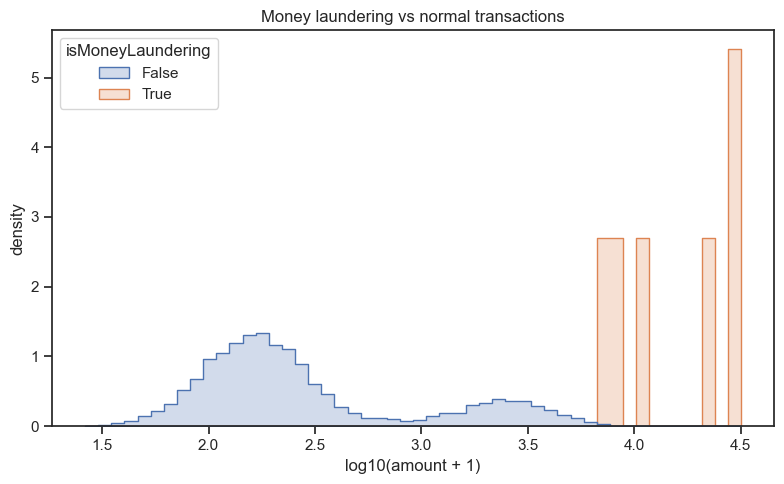

In [85]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(
    data=df,
    x=np.log10(df['amount'] + 1),
    hue='isMoneyLaundering',
    element='step',
    bins=50,
    stat='density',
    common_norm=False,
    ax=ax
)
ax.set_xlabel('log10(amount + 1)')
ax.set_ylabel('density')
ax.set_title('Money laundering vs normal transactions')
plt.tight_layout()
plt.show()

### Transaction Type and ML Probability
The barplot reflects the heterogeneity of risks for different payment types/methods.

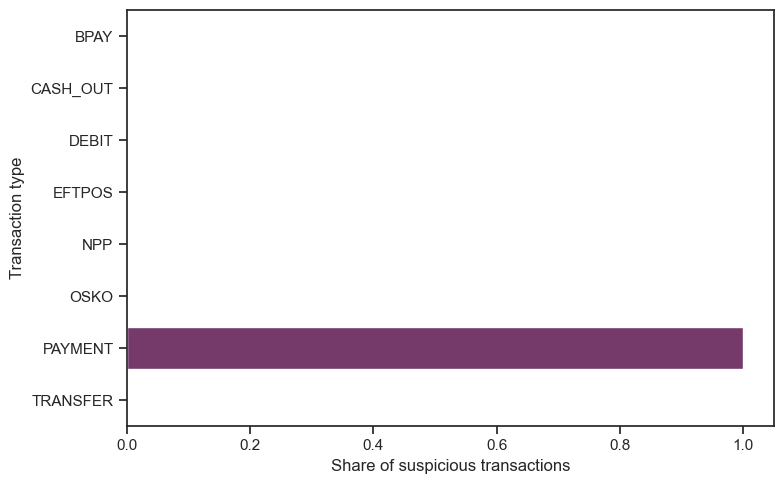

In [86]:
type_stats = (
    df.groupby('type', observed=True)
    .agg(tx_count=('step', 'count'), laundering_rate=('isMoneyLaundering', 'mean'))
    .reset_index()
    .sort_values('laundering_rate', ascending=False)
)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=type_stats,
    x='laundering_rate',
    y='type',
    palette='flare',
    ax=ax
)
ax.set_xlabel('Share of suspicious transactions')
ax.set_ylabel('Transaction type')
plt.tight_layout()
plt.show()

### Hourly profile
The line plots the ML probability by hour, and the columns plot the total number of operations.

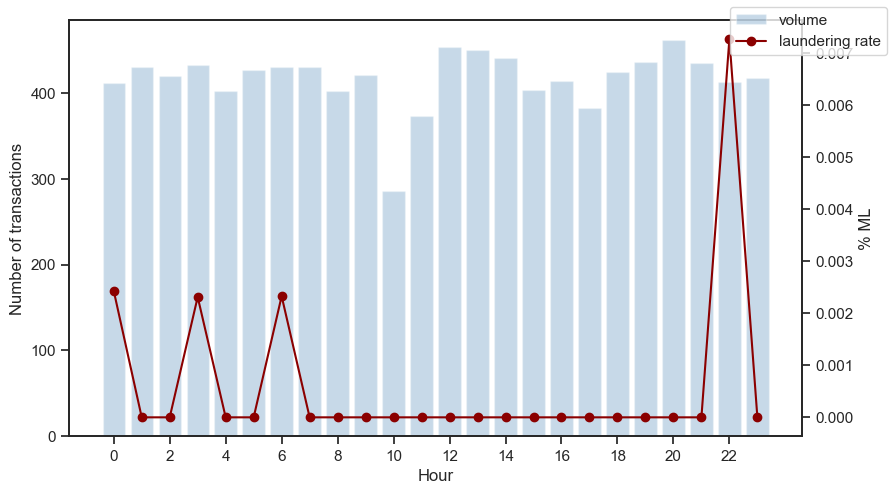

In [87]:
hourly = (
    df.groupby('hour', observed=True)
    .agg(
        laundering_rate=('isMoneyLaundering', 'mean'),
        volume=('step', 'count')
    )
    .reset_index()
)
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.bar(hourly['hour'], hourly['volume'], alpha=0.3, color='steelblue', label='volume')
ax2.plot(hourly['hour'], hourly['laundering_rate'], color='darkred', marker='o', label='laundering rate')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of transactions')
ax2.set_ylabel('% ML')
ax1.set_xticks(range(0, 24, 2))
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Risk score vs. actual target
Compare the model risk scores from the metadata with the actual labels.

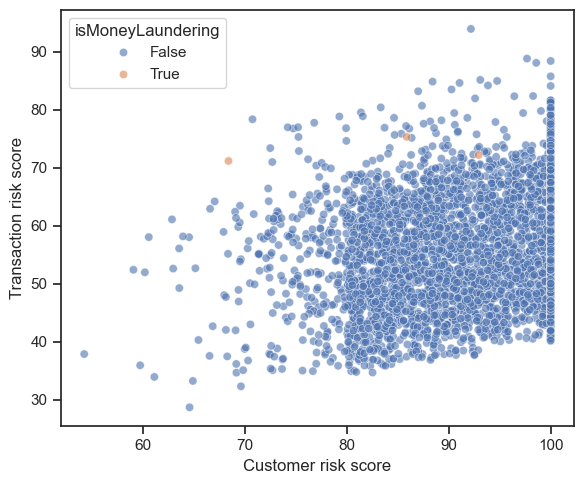

In [88]:
sample = df.sample(min(5000, len(df)), random_state=42)
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    data=sample,
    x='risk_customer_risk_score',
    y='risk_risk_score',
    hue='isMoneyLaundering',
    alpha=0.6,
    ax=ax
)
ax.set_xlabel('Customer risk score')
ax.set_ylabel('Transaction risk score')
plt.tight_layout()
plt.show()

## User split for training
We split the sample by user (nameOrig) to prevent a single client from being in both train and test. We also remove potentially leaky columns like `fraud_probability`.

In [89]:
model_df = df.drop(columns=['isFraud', 'isMoneyLaundering']).copy()
if 'timestamp' in model_df:
    model_df = model_df.drop(columns=['timestamp'])
if 'fraud_probability' in model_df:
    model_df = model_df.drop(columns=['fraud_probability'])

y = df['isMoneyLaundering'].astype(int)
groups = df['nameOrig']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(model_df, y, groups))

X_train, X_test = model_df.iloc[train_idx], model_df.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(
    f"Train users: {groups.iloc[train_idx].nunique()} | Test users: {groups.iloc[test_idx].nunique()}"
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Target rate train/test: {y_train.mean():.4f} / {y_test.mean():.4f}")

Train users: 2930 | Test users: 733
Train size: (8004, 50), Test size: (1996, 50)
Target rate train/test: 0.0007 / 0.0000


## Encoding pipeline
1. **Numerical features** are heavy-tailed, so we use `RobustScaler` after the media input.
2. **Low cardinality (<=8 unique)** → `OneHotEncoder` to preserve the interpretability of features (operation types, buckets).
3. **High cardinality** (`nameOrig`, `nameDest`, `device_ip_address`, `merch_merchant_id`, PayID, etc.) → smoothed target encoding on `isMoneyLaundering`. This allows us to retain the signal without a huge OHE matrix and reduces noise through flexible regularization. 4. **Group split** ensures that the target encoding does not "peep" into the test users: we fit the encoder only on train users and can easily wrap it in cross-fit in further experiments.

In [90]:
categorical_cols = model_df.select_dtypes(include=['object', 'category']).columns.tolist()
low_card_cols = [col for col in categorical_cols if model_df[col].nunique() <= 8]
ordinal_col = [i for i in low_card_cols if 'risk' in i]
low_card_cols = [c for c in low_card_cols if c not in ordinal_col]
high_card_cols = [col for col in categorical_cols if col not in low_card_cols]
numeric_cols = model_df.columns.difference(categorical_cols)

print(f'Low-card columns: {len(low_card_cols)}, Ordinal columns: {len(ordinal_col)}, High-card columns: {len(high_card_cols)}, Numeric: {len(numeric_cols)}')

Low-card columns: 9, Ordinal columns: 3, High-card columns: 8, Numeric: 33


In [73]:
class SmoothedTargetEncoder(BaseEstimator, TransformerMixin):
    '''Mean target encoding with logistic smoothing'''
    
    def __init__(self, smoothing: float = 20.0, min_samples: float = 50.0):
        self.smoothing = smoothing
        self.min_samples = min_samples
        self.global_mean_ = None
        self.mapping_ = {}

    def fit(self, X, y):
        X = pd.DataFrame(X).copy()
        y = pd.Series(y).astype(float)
        self.global_mean_ = y.mean()
        for col in X.columns:
            stats = (
                pd.DataFrame({col: X[col], 'target': y})
                .groupby(col)['target']
                .agg(['mean', 'count'])
            )
            smooth = 1 / (1 + np.exp(-(stats['count'] - self.min_samples) / self.smoothing))
            enc_values = self.global_mean_ * (1 - smooth) + stats['mean'] * smooth
            self.mapping_[col] = enc_values
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        encoded = pd.DataFrame(index=X.index)
        for col in X.columns:
            mapping = self.mapping_.get(col, {})
            encoded[col] = X[col].map(mapping).fillna(self.global_mean_)
        return encoded.values

In [41]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler())
])

low_card_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
    ('encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

"""high_card_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
    ('target', SmoothedTargetEncoder())
])"""

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, list(numeric_cols)),
        ('low_card', low_card_pipe, low_card_cols),
        ('high_card', high_card_pipe, high_card_cols)
    ],
    remainder='drop'
)

preprocessor.fit(X_train, y_train)
encoded_sample = preprocessor.transform(X_train.iloc[:200])
print('Encoded sample shape:', encoded_sample.shape)

Encoded sample shape: (200, 84)


## Conclusions
- The target is extremely sparse (~0.16%), so additional features are critical.
- Monetary transactions with the TRANSFER/PAYMENT types and large amounts are more often referred to as ML cases (cost-sensitive loss and focal loss should be tested).
- Next, you can add time windows (rolling features) and test cross-fitted target encoding or neural network embeddings for nameOrig/nameDest.